"""autoencoder_simulation2.ipynb
# Author:
Richard Bruce Baxter - Copyright (c) 2020-2024 Baxter AI (baxterai.com)

(test harness: The Tensorflow Authors)
# License:
Apache License, Version 2.0
# Installation:
Google Colab
# Usage:
Google Colab
# Description:
autoencoder_simulation2.ipynb - learning algorithm is based on AEANNtf (Autoencoder generated artificial neural network)
"""

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Input, Add

## Load the dataset
To start, you will train the basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Multilayer autoencoder (greedy training)

In [3]:
useActivationFunctionF = True   #optional
autoencoderPrediction = "inputLayer"    #required (AEORtf uses no supervised output, so must predict inputLayer)

numberOfLayers=4
numberOfEpochs = 10
batchSize = 32

imageSize = (28, 28)
multipleLayers = True
supportSkipLayers = True    #full connectivity to all previous layers
if(supportSkipLayers):
    residualConnections = False
else:
    residualConnections = True  #simple addition of previous layer output
simulateCorticalCircuit = True  #mandatory (single layer training)
firstLayerMultiplier = 2  #limited by tensorflow GPU memory

latent_dim = 64

class EncoderLX(Model):
  def __init__(self, latent_dim, io_dim, layerIndex):
    super(EncoderLX, self).__init__()
    self.layerIndex = layerIndex
    self.io_dim = io_dim
    self.latent_dim = latent_dim
    if(supportSkipLayers):
        self.encoders = []
        for i in range(layerIndex+1):
            encoder = tf.keras.Sequential([layers.Flatten(),
                                            layers.Dense(latent_dim, activation=None),])
            self.encoders.append(encoder)
    else:
        self.encoder = tf.keras.Sequential([layers.Flatten(),
                                            layers.Dense(latent_dim, activation=None),])
    if(useActivationFunctionF):
        self.encoderact = tf.keras.layers.Activation('relu')

  def call(self, inputs):
    x, inputLayer, AprevLayerAll = inputs
    if(supportSkipLayers):
        for i in range(self.layerIndex+1):
            if(i == 1):
                AprevLayerAll = tf.transpose(AprevLayerAll, perm=[2, 0, 1]) #keras functions require first dimension to be batchSize
            if(i > 0):
                Zpartial = self.encoders[i](AprevLayerAll[i-1]) #i-1: AprevLayerAll is defined without inputLayer
                encoded = tf.keras.layers.Add()([encoded, Zpartial])    #encoded = encoded + Zpartial
            else:
                Zpartial = self.encoders[i](inputLayer)
                encoded = Zpartial
    else:
        encoded = self.encoder(x)
        if(residualConnections):
            encoded = tf.keras.layers.Average()([encoded, AprevLayerAll])
    if(useActivationFunctionF):
        encoded = self.encoderact(encoded)
    return encoded


class AutoencoderLX(Model):
  def __init__(self, latent_dim, io_dim, layerIndex):
    super(AutoencoderLX, self).__init__()
    self.layerIndex = layerIndex
    self.latent_dim = latent_dim
    self.encoder = EncoderLX(latent_dim, io_dim, layerIndex)
    self.decoder = tf.keras.Sequential([layers.Dense(io_dim[0]*io_dim[1], activation='sigmoid'),
                                        layers.Reshape((io_dim[0], io_dim[1])),])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded



In [4]:
x = x_train
xv = x_test
inputLayer = x_train
inputLayerV = x_test
AprevLayerAll = x   #require to pass tensors to keras model (i=0 is not used; use inputLayer instead)
AprevLayerAllV = xv  #require to pass tensors to keras model (i=0 is not used; use inputLayer instead)
for l in range(numberOfLayers):
    print("l = ", l)
    if(l > 1):
        AprevLayerAll = np.concatenate((AprevLayerAll, np.expand_dims(x, axis=-1)), axis=-1)
        AprevLayerAllV = np.concatenate((AprevLayerAllV, np.expand_dims(xv, axis=-1)), axis=-1)
    elif(l == 1):
        AprevLayerAll = np.expand_dims(x, axis=-1)
        AprevLayerAllV = np.expand_dims(xv, axis=-1)
    autoencoderLX = AutoencoderLX(latent_dim, imageSize, l)
    autoencoderLX.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoderLX.fit([x, inputLayer, AprevLayerAll], x_train, epochs=numberOfEpochs, shuffle=False, batch_size=batchSize, validation_data=([xv, inputLayerV, AprevLayerAllV], x_test))
    out = autoencoderLX.predict([x, inputLayer, AprevLayerAll])
    outv = autoencoderLX.predict([xv, inputLayerV, AprevLayerAllV])
    x = autoencoderLX.encoder.predict([x, inputLayer, AprevLayerAll])
    xv = autoencoderLX.encoder.predict([xv, inputLayerV, AprevLayerAllV])
    decoded_imgs = outv


l =  0
Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0236 - val_loss: 0.0131
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
313/313 [==============================] - 0s 1ms/step
l =  1
E

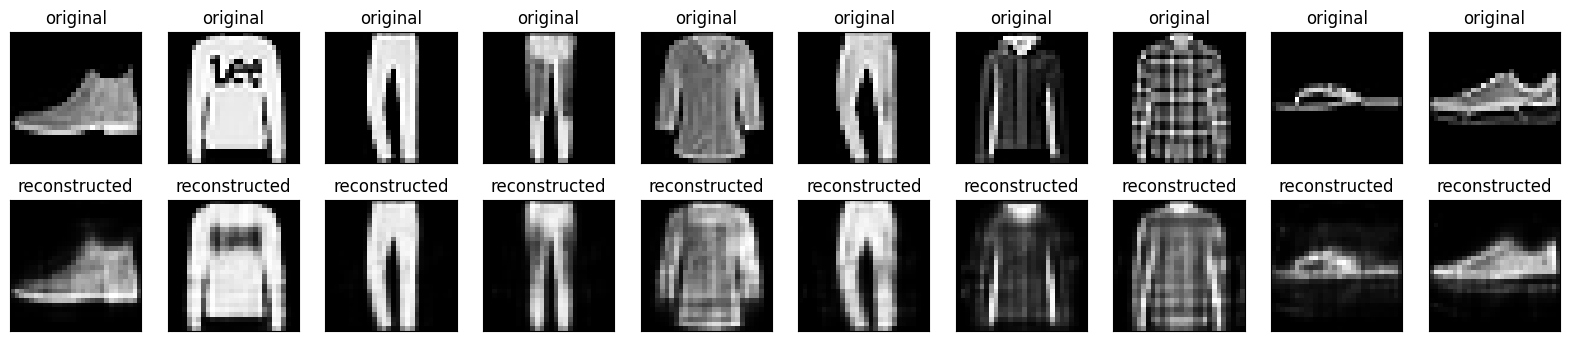

In [5]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()